# Phân Tích dữ liệu reviews của Amazon

Đây là tập dữ liệu Thương mại điện tử dành cho sản phẩm thời trang xoay quanh các bài đánh giá do khách hàng viết. Sáu tính năng hỗ trợ của nó đã (được trích xuất ra từ tập dữ liệu với 12 tính năng) cung cấp một môi trường tuyệt vời để phân tích văn bản thông qua nhiều chiều của nó.

# 1.0 Packages

In [ ]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline
from matplotlib.gridspec import GridSpec
import re
from sklearn.metrics import mean_squared_error, accuracy_score
from math import sqrt
from sklearn import metrics


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")

os.chdir('drive/My Drive/Colab Notebooks')
!pwd

# 2.0 phân tích sơ bộ


## 2.1 Overview

In [ ]:
#load the file
df = pd.read_csv('data/Clothing-Reviews.csv',index_col=False)

In [ ]:
df.head()


,asin,title,review_userId,review_score,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."
1,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A17ZI8VKZJFOV8,5,Great Classic,One of incantations best recordings. Im a fan ...
2,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2F9LXG1QEJ855,4,Very Original Debut of one of the most striden...,"This is an early, and rough-sounding look at t..."
3,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2FGXHSHF0OD17,5,No secret here,Whats to say about this album? Quintessential ...
4,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A2O2E8BLB7VW1U,5,Brings a smile to my face...,...Whenever i listing to an album by incantati...


In [ ]:
df['asin'].describe()

count          50046
unique          6584
top       B071NS6YRQ
freq             791
Name: asin, dtype: object

In [ ]:
df['review_userId'].describe()

count              50046
unique              6670
top       A1WFD3B0ULHZ7E
freq                 100
Name: review_userId, dtype: object

In [ ]:
df['review_score'].describe()

count    50046.000000
mean         4.121648
std          1.290461
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64

In [ ]:
#Quick change: rename "asin" to itemID for easy look
df.rename(columns={"asin": "ItemID"}, inplace = True);

In [ ]:
df.head(2)

,ItemID,title,review_userId,review_score,review_summary,review_text
0,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A174NPQZ1EABX1,5,"Fundamental of death metal, do not miss","A roaring onslaught of streaming sound, this a..."
1,B004GSI2OS,Featherlite Ladies' Long Sleeve Stain Resistan...,A17ZI8VKZJFOV8,5,Great Classic,One of incantations best recordings. Im a fan ...


In [ ]:
df.shape

(50046, 6)

In [ ]:
df.dtypes

ItemID            object
title             object
review_userId     object
review_score       int64
review_summary    object
review_text       object
dtype: object

In [ ]:
df.describe()

,review_score
count,50046.000000
mean,4.121648
std,1.290461
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
#Look up a random review
df['review_text'][9999]

'The best. Have tried all kinds and keep coming back...Excellant for large size bra wearers. Never cuts in or sags, it is just very comfortable and lets you look nice in your clothes.'

Văn bản đánh giá mẫu ở trên cho thấy rằng có thể trích xuất một số chi tiết nhất định về người dùng như:
- measurements(số đo) (height, bust size)
- recurring words(từ lập lại)
- positive/negative adjectives (perfect, unique, cute)
- verbs (love)
- use of punctuation(dấu câu) (!,?, !?, -, etc...)



In [ ]:
#Unique entry in each column
df.nunique()

ItemID             6584
title              6584
review_userId      6670
review_score          5
review_summary    36048
review_text       49959
dtype: int64

In [ ]:
# Null Entries
df.isna().sum()

ItemID               0
title                0
review_userId        0
review_score         0
review_summary    2892
review_text          0
dtype: int64

In [ ]:
#List unique review_score (points of rate)
df['review_score'].value_counts()

5    29366
4     8932
3     4406
1     4188
2     3154
Name: review_score, dtype: int64

## 2.2 Visualizations

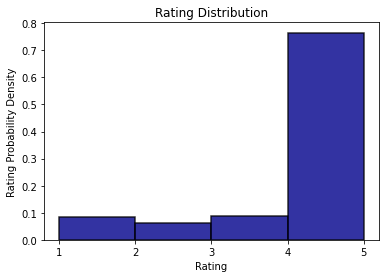

In [ ]:
#Create bin for rating
rating_bin = np.arange(1, 6, 1)

#Create histogram
plt.hist(df['review_score'], bins = rating_bin, alpha = 0.8, edgecolor='black', linewidth =1.5, color ='darkblue', density= 1)

#Add labels and title
plt.xlabel("Rating")
plt.ylabel("Rating Probability Density")
plt.title("Rating Distribution")

#Set x axis ticks to match bins
plt.xticks(rating_bin)

plt.show()

Biểu đồ rõ ràng bị lệch sang phải. Đa số đánh giá là tích cực.


### **Heavily Rated Items**

In [ ]:
df_n_ratings = pd.DataFrame(df.groupby('title')['review_score'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df.groupby('title')['review_score'].count())
df_n_ratings.rename(columns = {'review_score': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"OUBAO Womens Strapless Sexy Print Top (XL, Blue)",4.441214,791
"Unibelle Women Casual Cutout Long Sleeve T-shirt Top(Wine Red,XXL)",3.401266,790
"C/Meo Womens Collective Fiction Open Back Tie Shirt, S, Black",4.562264,530
Lovers + Friends Deep Sea Bodysuit Large in Navy Stripe,4.342949,312
Qmack Long-sleeve Plaid Satin Blouse XS Coral Combo,4.270096,311
Dylan Gray Women's Keyhole Wrap Blouse in Spectrum Blue Size X-Large,4.242958,284
Flying Cross 126R5435 Women's Long Sleeve Duro Poplin Uniform Shirt Blue (38 Short),3.003546,282
"Who What Wear Women's Short Sleeve Crew Neck Top, Medium, Black/White Striped",4.136201,279
Girls' Short Sleeve Lace Shoulder Tee,4.323529,272


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


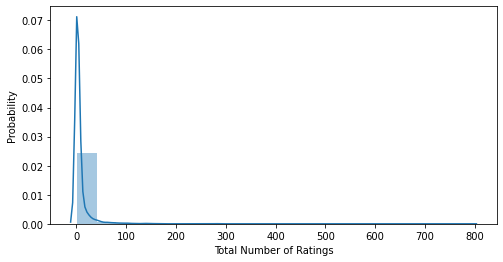

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

### **Highly Rated Items**

In [ ]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Éclair Women's Printed Thin Strap Blouse Black - Junior XL,5.0,1
RO & DE Womens Medium Abstract Tie Split Neck Blouse Green M,5.0,2
"Ella Moon Women's Solana Long Sleeve Tie Neck Cold Shoulder Blouse, Army/Blush, Medium",5.0,2
"Ella Moon Womens Baylee 3/4 Kimono Sleeve Printed Top, Aqua Print, Small",5.0,1
"Ella Moon Womens Cecile 3/4 Bell Sleeve Embroidered Cotton Check Top, Ivory/Orange, Small",5.0,1
"Rag & Bone / JEAN Classic Raglan Pullover, Black, Small",5.0,1
Racerback Tank Top Ribbed by Wishful Park Size Medium,5.0,1
"Ella Moon Womens Jayde Long Bell Sleeve on and Off Shoulder Lace Trim Top, Chambray/Ivory, Small",5.0,2
Ellen Tracy Company Ladies' Roll Tab Medium Size Linen Tunic (Chalk),5.0,1


In [ ]:
print('Total no of users that gave rating of 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of Individual users that gave rating of 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Total no of users that gave rating of 5.0 :  2278 

Total no of Individual users that gave rating of 5.0 :  1740


tổng cộng có 2278 sản phẩm có người dùng cho 5 sao trong đó chỉ có 1740 sản phẩm có duy nhất cá nhân người dùng cho 5 sao. Vì vậy, đây không thể là yếu tố duy nhất nên được xem xét khi giới thiệu sản phẩm. Vì yếu tố này chỉ hiển thị sở thích của một người dùng cụ thể. Sẽ là hệ thống gợi ý tốt nếu ta kết hợp cả hai thứ sản phẩm được bình chọn nhiều nhất và sản phẩm được bình chọn cao nhất.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


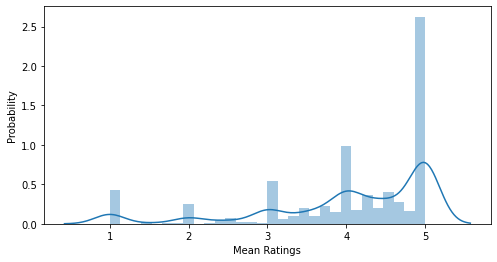

In [ ]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

### **Mean Ratings vs Total Number of Ratings**

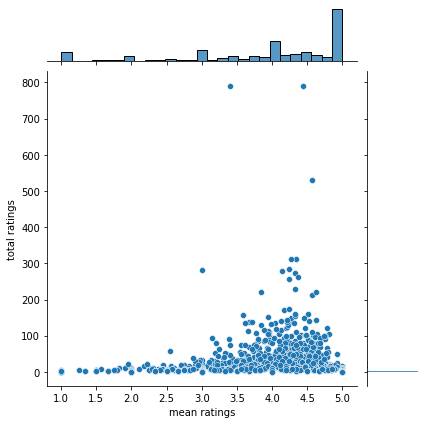

In [ ]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

Ở đây, có thể thấy mỗi Điểm dữ liệu đại diện cho một item riêng biệt, với tọa độ y đại diện cho tổng số người dùng đã xếp hạng item đó và tọa độ x đại diện cho giá trị trung bình của tất cả xếp hạng của những người dùng tương ứng.<br>
Ngoài ra,  có thể thấy rằng có một Mật độ rất lớn trong khu vực tương ứng với 0-200 lượt đánh giá và giữa xếp hạng trung bình 4-4.5


# 3.0 Cleaning dữ liệu

In [ ]:
#Check for empty reviews
pd.isna(df['review_text']).sum()

0

In [ ]:
#Drop all empty reviews
df_temp = df.dropna(subset=['review_text', 'title'])

In [ ]:
#Data Left 
df_temp.shape[0] /df.shape[0]

1.0

In [ ]:
#Reset index
df_index = df_temp.reset_index()

In [ ]:
#Check for empty reviews
for i in range(df_index.shape[0]):
    if pd.isna(df_index['review_text'][i]) == True:
        print(i)

In [ ]:
#Store reviews in list
review_text = np.array(df_index['review_text'])

In [ ]:
#Make all entires lower case
for i in range(len(review_text)):
    review_text[i] = review_text[i].lower()
    

In [ ]:
#Store title in list
title = np.array(df_index['title'])

# 4.0 Word Cloud

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path 

In [ ]:
df['review_text'][0]

'A roaring onslaught of streaming sound, this album moves away from the choppy, explosive riffing which emphasized guitar as percussion instrument. Instead, texture and shape are emphasized in highly relativistic phrases which narrate the development of themes like a classical pop piece. Unholy bass-heavy vocals merge with detuned distorted guitar and deathlike prowling bass, creating a peristaltic wash of sonic attack that is irresitably violent and well-composed. Of the many early death metal releases, this one stands the test of time.'

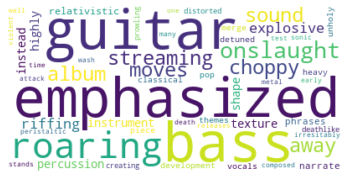

In [ ]:
#Try on the first review
word_cloud_0 = WordCloud(background_color="white", max_font_size= 100).generate(review_text[0])
#Display the image
plt.imshow(word_cloud_0, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Combine all the reviews into one massive string
review_text_combined = " ".join(review for review in review_text)
print ("There are {} words in the combination of all reviews.".format(len(review_text_combined)))

There are 16365535 words in the combination of all reviews.


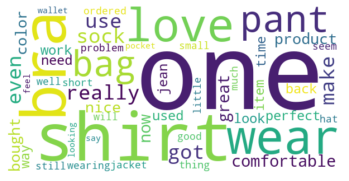

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
#For now let's only remove the
stopwords.update(["the"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      width= 600, height = 300, 
                      max_words=50).generate(review_text_combined)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Define mask for cloud
cloud_mask = np.array(Image.open("plots/young_woman_shop.jpg"))

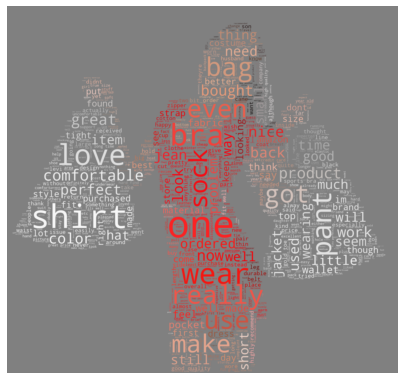

In [ ]:
wordcloud_shop = WordCloud(stopwords=stopwords, 
                           background_color="grey", 
                           mode="RGBA", max_words=1000, 
                           mask=cloud_mask).generate(review_text_combined)

# create coloring from image
image_colors = ImageColorGenerator(cloud_mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_shop.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")



plt.show()

In [ ]:
# store to file
plt.savefig("plots/woman_shop.png", format="png")

<Figure size 432x288 with 0 Axes>

# 5.0 Phân Tích Cảm nhận



Thực hiện phân tích tình cảm thô sơ và kiểm tra mối tương quan với xếp hạng.<br>
Danh sách các từ tích cực / tiêu cực có thể được mở rộng thành tùy chọn hoặc thay thế bằng danh sách được tạo sẵn.<br>
The list positive/negative words can be expanded to preference or replaced by a ready-made list.<br>
Lưu ý: không thực hiện bất kỳ thao tác lemmetization nào và giả định rằng tất cả các từ đều được viết đúng chính tả mà không có nguyên âm / phụ âm thừa.


In [ ]:
#Define a list of positive expressions
pos_word = ['love', 'good', 'great', 'amazing', 'super', 'smooth', 'fits', 'nice', 'perfect', 'cute', 'recommend',
           'like']

In [ ]:
#Define a list of negative words
neg_word = ['hate', 'bad', 'horrible', 'big', 'small', 'rough', 'ugly', 'itch', 'expensive', 'scratch', 'never',
           'dislike', 'ill', 'poor', 'smelly']

In [ ]:
#Create a list that will record sentiment.
# Add one if positive and substract one if negative.
sentiments = np.zeros(len(review_text))

In [ ]:
#Start by adding scores

for j in range(len(pos_word)):
#Iterate over every positive word
    for i in range (len(review_text)):
    #Divide the string into a list of words in case one positive word is used more than once
        sep_words = re.sub("[^\w]", " ", str(review_text[i])).split()
        #Compare word for word if the sentiment is good
        for k in range(len(sep_words)):
            if pos_word[j] == sep_words[k]:
                sentiments[i] += 1
        
    

In [ ]:
#Check the overall sentiment after positives
np.mean(sentiments)

1.3478399872117652

In [ ]:
#Repeat some thing but now with negative words
#Start by adding scores

for j in range(len(neg_word)):
#Iterate over every positive word
    for i in range (len(review_text)):
    #Divide the string into a list of words in case one negative word is used more than once
        sep_words = re.sub("[^\w]", " ", str(review_text[i])).split()
        #Compare word for word if the sentiment is good
        for k in range(len(sep_words)):
            if neg_word[j] == sep_words[k]:
                sentiments[i] -= 1
        

In [ ]:
#Check the overall sentiment after negatives
np.mean(sentiments)

1.0357271310394438

In [ ]:
#Store the review score in array
review_score = np.array(df_index['review_score'])

In [ ]:
len(review_score)

50046

In [ ]:
len(sentiments)

50046

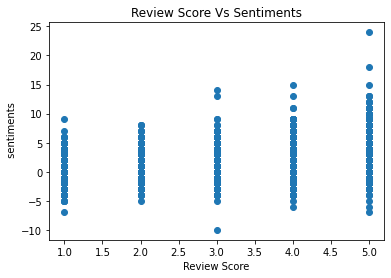

In [ ]:
#Draw a scatter plot
plt.scatter(x= review_score, y = sentiments)

#Add labels and title
plt.xlabel("Review Score")
plt.ylabel(" sentiments")
plt.title("Review Score Vs Sentiments")


plt.show()


 Lặp lại bằng cách chuyển ý kiến ​​trung bình vào  review score bin.

In [ ]:
#Create review bin
rate_1 = []
rate_2 = []
rate_3 = []
rate_4 = []
rate_5 = []

In [ ]:
for x in range(len(review_text)): 
  print(review_text[x])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sep_words = re.sub("[^\w]", " ", str(review_text[1])).split()
for i in range(len(sep_words)):
  print(sep_words[i])

one
of
incantations
best
recordings
im
a
fan
of
their
newer
stuff
but
this
record
really
did
start
a
wave
of
clones
get
the
new
album
infernal
storm
and
diabolical
conquest
good
stuff


In [ ]:
feel_score = 0

for i in range (len(review_text)):
    #Divide the string into a list of words in case one positive word is used more than once
    sep_words = re.sub("[^\w]", " ", str(review_text[i])).split()
   
    #Compare word for word if the sentiment is good
    for k in range(len(sep_words)):
        for j in range(len(neg_word)):
            if neg_word[j] == sep_words[k]:
                feel_score -= 1
        for m in range(len(pos_word)):
            if pos_word[m] == sep_words[k]:
                feel_score += 1
    #Normalize the feel score over the length of the review
    feel_score = feel_score/len(sep_words)
    if review_score[i] == 1:
        rate_1.append(feel_score)
    elif review_score[i] == 2:
        rate_2.append(feel_score)
    elif review_score[i] == 3:
        rate_3.append(feel_score)
    elif review_score[i] == 4:
        rate_4.append(feel_score)
    elif review_score[i] == 5:
        rate_5.append(feel_score)
    #reset feel score for next iteration
    feel_score = 0

In [ ]:
#Store sentimetns in array
feels_tick = np.array([rate_1, rate_2, rate_3, rate_4, rate_5])

In [ ]:
feels_mean = []
for i in range(len(feels_tick)):
    feels_mean.append(np.mean(feels_tick[i]))

In [ ]:
feels_mean

[0.0019355263745195494,
 0.0082116901543628,
 0.012621809976394123,
 0.02480125981112618,
 0.029882962579348336]

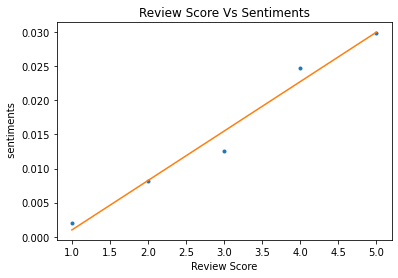

In [ ]:
from numpy.polynomial.polynomial import polyfit

#fit the data
b, m = polyfit(x = rating_bin, y = feels_mean, deg= 1)

#Draw a scatter plot
plt.plot(rating_bin, feels_mean, '.')
#draw the fit
plt.plot(rating_bin, b + m * rating_bin, '-')

#Add labels and title
plt.xlabel("Review Score")
plt.ylabel(" sentiments")
plt.title("Review Score Vs Sentiments")


plt.show()

Điểm đánh giá có tương quan thuận với tình cảm tích cực. <br>
NOTE: trong số các đánh giá rất thấp, cảm nhận vẫn tích cực có nghĩa là danh sách các từ tiêu cực có thể không hiệu quả. Nó cũng có thể có nghĩa là những người yêu thích một sản phẩm có thể dài dòng hơn nếu được yêu cầu mô tả trải nghiệm của họ.
.